In [39]:
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import copy
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch import sigmoid
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import torch.optim as optim

from tqdm.notebook import tqdm

## Preparing Dataset

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [41]:
# dataset loading
card = pd.read_csv("creditcard.csv", low_memory=False)

# 시간 정보 활용
card['Time'] = card['Time']%86400


print(card.Class.value_counts())

# feature / labels 분리
features = card.iloc[:,:-1]
labels = card.iloc[:,-1:]

# train/valid/test = 6/2/2
train_index = int(len(card) * 0.6)
valid_index = int(len(card) * 0.8)
X_train, y_train = features.iloc[:train_index,:], labels.iloc[:train_index,:]
X_val, y_val = features.iloc[train_index:valid_index,:], labels.iloc[train_index:valid_index,:]
X_test, y_test = features.iloc[valid_index:,:], labels.iloc[valid_index:,:]

0    284315
1       492
Name: Class, dtype: int64


In [42]:
card

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,86386.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,86387.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,86388.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,86388.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [43]:
# 정상데이터로만 학습하기 위해 trainset의 anomaly data 제외
anomaly_idx = y_train[y_train['Class'] == 1].index
X_train = X_train.drop(anomaly_idx)
y_train = y_train.drop(anomaly_idx)

In [44]:
# minmaxscaler 사용
scaler = MinMaxScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# dataloader 사용
X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train.values).float()
X_val = torch.from_numpy(X_val).float()
y_val = torch.from_numpy(y_val.values).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test.values).float()

train = TensorDataset(X_train, y_train)
val = TensorDataset(X_val, y_val)
test = TensorDataset(X_test, y_test)

train_loader = DataLoader(train, batch_size=256, shuffle=True)
val_loader = DataLoader(val, batch_size=256, shuffle=True)
test_loader = DataLoader(test, batch_size=256, shuffle=True)

## Model

In [46]:
# PARAMETER / HYPERPARAMETER

n_features = 30
num_epochs = 100
learning_rate = 0.005

In [47]:
# Autoencoder 모델 구현

# encoder 구현
class Encoder(nn.Module):
  def __init__(self, n_features):
    super(Encoder, self).__init__()

    self.n_features = n_features
    
    self.encoder = nn.Sequential(
        nn.Linear(n_features, 100),
        nn.ReLU(),
        nn.Linear(100, 70),
        nn.ReLU(),
        nn.Linear(70, 40),
        # nn.ReLU(),
        # nn.Linear(4, 2),
    )

  def forward(self, x):

    return self.encoder(x)

# decoder 구현
class Decoder(nn.Module):

  def __init__(self, n_features):
    super(Decoder, self).__init__()

    self.n_features = n_features
    
    self.decoder = nn.Sequential(
        nn.Linear(40, 40),
        nn.ReLU(),
        nn.Linear(40, 70),
        nn.ReLU(),
        nn.Linear(70, 100),
        nn.ReLU(),
        nn.Linear(100, n_features)
    )

  def forward(self, x):

    return self.decoder(x)
class Autoencoder(nn.Module): 

  def __init__(self, n_features):
    super(Autoencoder, self).__init__()

    self.encoder = Encoder(n_features)
    self.decoder = Decoder(n_features)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x


In [48]:
model = Autoencoder(n_features)
# model = model.to(device)

In [49]:
# FNN-defalut 학습/평가
def train_model(model, train_dataset, val_dataset, n_epochs):
    latent_space = []
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss(reduction='sum')#.to(device)
    history = dict(train=[], val=[]) 

    best_model_wts = copy.deepcopy(model.state_dict()) 
    best_loss = 10000.0
  
    for epoch in range(1, n_epochs + 1):
        model.train()

        train_losses = []
        for data, target in train_dataset: 
            optimizer.zero_grad()

            # data = data.to(device)
            # target = target.to(device)
            seq_pred = model(data)
            # print(seq_pred.shape) # (32, 29)
            loss = criterion(seq_pred, data)
            # print(loss)
            loss.backward() 
            optimizer.step() 

            train_losses.append(loss.item()) 
            
        val_losses = []

        model.eval() 
        with torch.no_grad():
            for data, target in val_dataset:

                # data = data.to(device)
                # target = target.to(device)
                seq_pred = model(data) 

                loss = criterion(seq_pred, data)
                val_losses.append(loss.item()) 
                # if epoch == n_epochs :
                #     latent_space.append(latent)


        train_loss = np.mean(train_losses) 
        val_loss = np.mean(val_losses)

        history['train'].append(train_loss)
        history['val'].append(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

            
        print(f'Epoch {epoch}: train loss {train_loss/len(train_dataset)} val loss {val_loss/len(val_dataset)}')

    model.load_state_dict(best_model_wts)
    return model, history

In [50]:
model, history= train_model(
  model, 
  train_loader, 
  val_loader, 
  num_epochs
)

Epoch 1: train loss 0.06818511751358973 val loss 0.07918931204356618
Epoch 2: train loss 0.023532615891408912 val loss 0.07312828947584016
Epoch 3: train loss 0.020828388482445774 val loss 0.059978735641341104
Epoch 4: train loss 0.01343055746305591 val loss 0.045499702852810624
Epoch 5: train loss 0.010415681559646235 val loss 0.03669310711120005
Epoch 6: train loss 0.008087943192728899 val loss 0.030235158011316352
Epoch 7: train loss 0.006799401063765734 val loss 0.034910364425621745
Epoch 8: train loss 0.006662002909673829 val loss 0.0321519879117881
Epoch 9: train loss 0.005849590813268842 val loss 0.03286257035440437
Epoch 10: train loss 0.004598297040397848 val loss 0.021629787718269997
Epoch 11: train loss 0.00398116050776664 val loss 0.018502453678097122
Epoch 12: train loss 0.003785742339569745 val loss 0.0215081590235817
Epoch 13: train loss 0.00356843945360238 val loss 0.018301075023457892
Epoch 14: train loss 0.0032672643514258916 val loss 0.01822383337999498
Epoch 15: tra

### training loss

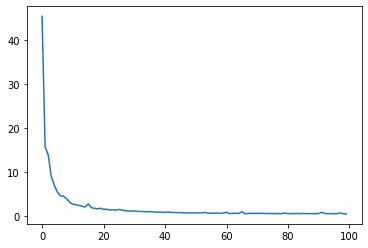

In [51]:
plt.plot(history['train'])

# test set 평가 : reconstruction error, confusion matrix, f1-score, PR-AUC

In [52]:
# testset 모델에 넣어 예측
def test(model, test_loader):
    criterion = nn.MSELoss(reduction='none').to(device)

    test_loss = []
    input_ =[]
    output_ = []
    # latent_ = []
    real_ = []
    model.eval()
    with torch.no_grad():
        for data, target in test_loader:
            # seq_true = data.to(device)
            # seq_true = seq_true.float()
            seq_pred = model(data)  # seq_true is the test dataset
            loss = criterion(
                    seq_pred, data
                )
            # # print(loss)
            # print(loss.shape) # (32, 29)
            # t_loss = loss
            # print(t_loss.shape) # 32
            test_loss.append(loss)
            input_.append(data)
            output_.append(seq_pred)
            # latent_.append(latent)
            real_.append(target)
            # print(test_loss)

        return input_, output_, real_, test_loss
            

In [53]:
input_,output_,real_,loss_ = test(model, test_loader)

### plot reconstruction error

In [54]:
input_
input_1 = np.array([a.cpu().numpy().tolist() for b in input_ for a in b])
output_1 = np.array([a.cpu().numpy().tolist() for b in output_ for a in b])
real_1 = np.array([a.cpu().numpy().tolist() for b in real_ for a in b])
loss_1 = np.array([a.cpu().numpy().tolist() for b in loss_ for a in b])

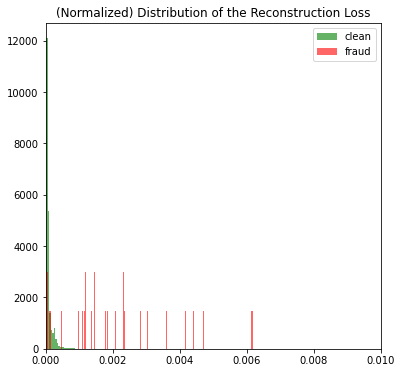

In [55]:
# reconstruction error 확인 및 throshold 파악
import matplotlib.pyplot as plt

mse = np.mean(np.power(input_1-output_1, 2), axis=1)
mse_df = pd.DataFrame(mse, columns=['loss'])
clean = mse_df[real_1==0]
fraud = mse_df[real_1==1]
fig, ax = plt.subplots(figsize=(6,6))

ax.hist(clean.values, bins=1000, density=True, label="clean", alpha=.6, color="green")
ax.hist(fraud.values, bins=1000, density=True, label="fraud", alpha=.6, color="red")

plt.title("(Normalized) Distribution of the Reconstruction Loss")
plt.xlim([0,0.01])
# plt.ylim([50,500])
plt.legend()
plt.show()


### confusion matrix

In [56]:
# 위에서 확인한 reconstruction error 기반 threshold 지정
threshold = 0.001

fraud_index = mse_df.loc[mse_df.loss > threshold].index
result_df = pd.DataFrame(real_1, columns=['result']).loc[fraud_index]
result_df.result.value_counts()

real_1_df = pd.DataFrame(real_1, columns=['result'])
real_1_df.result.value_counts()

pred = [1 if i > threshold else 0 for i in mse_df.loss]

In [94]:
# confusion matrix 확인
confusion_matrix(real_1,pred)

array([[56577,   310],
       [   19,    56]])

In [95]:
# f1 score 및 기타 지표 확인
print(classification_report(real_1,pred))

              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00     56887
         1.0       0.15      0.75      0.25        75

    accuracy                           0.99     56962
   macro avg       0.58      0.87      0.63     56962
weighted avg       1.00      0.99      1.00     56962



### PR-AUC curve

In [58]:
# PR-AUC curve 확인
from sklearn.metrics import precision_recall_curve, average_precision_score 
def pr_auc(target, losses):

    precision, recalls, threshold = precision_recall_curve(target, losses) # _ = threshold
    average_precision = average_precision_score(target, losses)
    # print(precision)
    # print(recalls)
    # print(threshold)
    print("Average precision-recall score: {0:.4f} ".format(average_precision))

    # plot
    plt.figure(figsize=(10, 5))
    plt.plot(recalls, precision, label="precision & recall")
    plt.xlabel("recall")
    plt.ylabel("precision")
    plt.legend()
    plt.grid()
    plt.show()

In [59]:
reconst_error = np.mean(loss_1,axis=1)
reconst_error.shape

(56962,)

In [60]:
loss_1

array([[3.41823412e-04, 9.73815168e-06, 8.26011274e-07, ...,
        2.15305499e-05, 3.33129537e-06, 6.70601457e-06],
       [3.79623292e-04, 5.19784226e-06, 3.36543349e-06, ...,
        7.21888637e-06, 9.92834543e-07, 2.53127882e-06],
       [3.43281805e-04, 2.26283591e-05, 9.29867952e-08, ...,
        1.03106586e-05, 8.72420628e-07, 5.17419767e-06],
       ...,
       [2.05366829e-04, 1.27493004e-05, 3.96089241e-08, ...,
        5.87683426e-05, 4.20511697e-07, 1.30275589e-06],
       [1.92790510e-04, 6.40718063e-05, 2.27714864e-07, ...,
        1.38303119e-04, 4.94550569e-08, 6.92637343e-07],
       [3.20315768e-04, 1.64245575e-04, 2.58832097e-05, ...,
        3.37106627e-07, 1.52250477e-05, 1.57422292e-05]])

In [61]:
real_1.shape

(56962, 1)

Average precision-recall score: 0.1923 


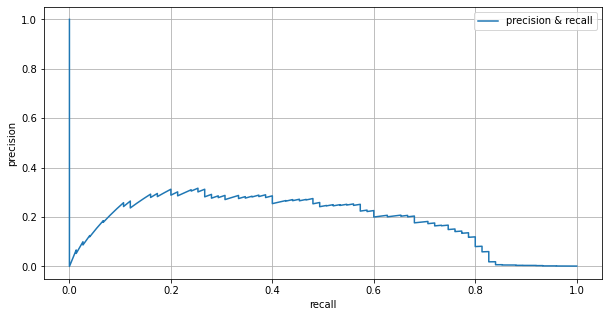

In [62]:
pr_auc(real_1,reconst_error)

# Latent space + logistric regression

### Load latent space

In [96]:
# 위에서 학습된 autoencoder 에서 encoder output (latent vector) 확인
encoded_ = []
target_ = []
for data, target in val_loader:
        # seq_true = data.to(device)
        # seq_true = seq_true.float()
        seq_encoded = model.encoder(data)  # seq_true is the test dataset
        encoded_.append(seq_encoded)
        target_.append(target)

In [97]:
encoded_1 = np.array([a.detach().numpy().tolist() for b in encoded_ for a in b])
target_1 = np.array([a.detach().numpy().tolist() for b in target_ for a in b])

In [98]:
print(encoded_1.shape)
print(target_1.shape)

(56961, 40)
(56961, 1)


### Classification with logistic regression

In [129]:
# 위에서 가져온 latent vector 를 통해 분류 모델(logistic regression) 학습

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
# clf = LogisticRegression()
clf = SVC(kernel="rbf")
clf.fit(encoded_1, target_1.ravel())

SVC()

# test set 평가 : confusion matrix, f1-score, PR-AUC 

In [130]:
test_encoded_ = []
test_target_ = []
for data, target in test_loader:
    seq_encoded = model.encoder(data)  # seq_true is the test dataset
    test_encoded_.append(seq_encoded)
    test_target_.append(target)
test_encoded_1 = np.array([a.detach().numpy().tolist() for b in test_encoded_ for a in b])
test_target_1 = np.array([a.detach().numpy().tolist() for b in test_target_ for a in b])

In [131]:
test_y_pred = clf.predict(test_encoded_1)
# test_y_prob = clf.predict_proba(test_encoded_1)

In [132]:
test_y_prob_1 = [i[1] for i in test_y_prob]
# test_y_prob_1

In [133]:
test_y_pred.shape
test_target_1.shape

(56962, 1)

### confusion matrix

In [134]:
confusion_matrix(test_target_1,test_y_pred)

array([[56885,     2],
       [   41,    34]])

In [135]:
x_en_test = [i[0] for i in test_encoded_1]
y_en_test = [i[1] for i in test_encoded_1]

### f1-score

In [107]:
print(classification_report(test_target_1,test_y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56887
         1.0       0.94      0.45      0.61        75

    accuracy                           1.00     56962
   macro avg       0.97      0.73      0.81     56962
weighted avg       1.00      1.00      1.00     56962



### PR-AUC curve

Average precision-recall score: 0.7375 


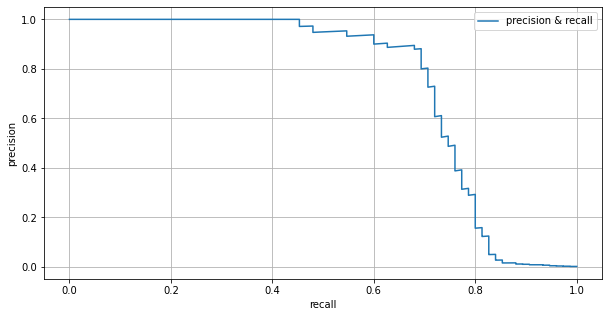

In [74]:
pr_auc(test_target_1,test_y_prob_1)